In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os

In [20]:
sessions = np.arange(25, 76)
data=[]

for session in sessions:
    directory = "../../data/TXT/Session "+str(session)+" - "+str(1945+session)
    for filename in os.listdir(directory):
        f = open(os.path.join(directory, filename), encoding="utf8")
        if filename[0]==".": #ignore hidden files
            continue
        splt = filename.split("_")
        data.append([session, 1945+session, splt[0], f.read()])

        
df_speech = pd.DataFrame(data, columns=['Session','Year','ISO-alpha3 Code','Speech'])

df_speech.tail()

pd.set_option("display.max_rows", None, "display.max_columns", None)


In [21]:
happinessdataframe = pd.read_excel('DataPanelWHR2021C2.xls')
pd.set_option("display.max_rows", None, "display.max_columns", None)


In [22]:
methodology = pd.read_csv("UNSD — Methodology.csv", delimiter = ";")
methodology = methodology.replace("United States of America", "United States")

In [23]:
happyCodes = pd.merge(happinessdataframe.loc[:,:], methodology.loc[:, ["Country or Area", "ISO-alpha3 Code"]], left_on="Country name", right_on="Country or Area")

In [24]:
happyUN = pd.merge(happyCodes.loc[:,:], df_speech.loc[:,:], left_on=["year","ISO-alpha3 Code"], right_on=["Year","ISO-alpha3 Code"], how="inner")


In [25]:
HappyUN = happyUN.set_index(["Year",'ISO-alpha3 Code'])

In [26]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rikva\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rikva\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rikva\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [27]:
from nltk.probability import FreqDist
from nltk import word_tokenize
from nltk.corpus import stopwords    

#append the country name as many times as referenced by any country other than itself
def preprocess2(words,country,allCountries):
    sw = stopwords.words("english")
    no_sw = []
    for w in words:
        if (w not in sw and w.isalpha() and w != country and w in allCountries):        
            no_sw.append(w.lower())
    return no_sw  
        
#List of all country names
allCountries = HappyUN[["Country name"]].values.ravel()
countryCodes = {}
#map country name to country code
for index, row in HappyUN.iterrows():
    country = row["Country name"]
    year,code = index
    countryCodes[country] = code
    
    
occurrences = {}

#count the number of references
for index, row in HappyUN.iterrows():
    country = row["Country name"]
    year = row["year"]
    words = word_tokenize(row["Speech"])
    words = preprocess2(words,country,allCountries)
    freq = FreqDist(words)
    #loop through the countries mentioned in the speech of a given country (A) at a given year
    for mentionedCountry in freq:
        #create a key composed of the year of the speech and the country that was referenced by country A
        newKey = (year,countryCodes[mentionedCountry.capitalize()])
        
        if newKey not in occurrences:
            occurrences[newKey] = freq[mentionedCountry]
        else:
            #if the country had already been mentioned previously (before country A), the key in the dictionary already exists 
            #hence, add new number of references 
            occurrences[newKey] = occurrences[newKey] + freq[mentionedCountry]


In [28]:
HappyUN['References'] = HappyUN.index.to_series().map(occurrences)
HappyUN.head()

,,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Country or Area,Session,Speech,References
Year,ISO-alpha3 Code,,,,,,,,,,,,,,,
2008,AFG,Afghanistan,2008,3.723590,7.370100,0.450662,50.799999,0.718114,0.167640,0.881686,0.517637,0.258195,Afghanistan,63,Since the last time we \ngathered here in this...,68.0
2009,AFG,Afghanistan,2009,4.401778,7.539972,0.552308,51.200001,0.678896,0.190099,0.850035,0.583926,0.237092,Afghanistan,64,"First, I would like to \ncongratulate His Exce...",87.0
2010,AFG,Afghanistan,2010,4.758381,7.646709,0.539075,51.599998,0.600127,0.120590,0.706766,0.618265,0.275324,Afghanistan,65,I join previous \nspeakers in congratulating y...,84.0
2011,AFG,Afghanistan,2011,3.831719,7.619532,0.521104,51.919998,0.495901,0.162427,0.731109,0.611387,0.267175,Afghanistan,66,I am honoured to be \nhere to read the stateme...,70.0
2012,AFG,Afghanistan,2012,3.782938,7.705479,0.520637,52.240002,0.530935,0.236032,0.775620,0.710385,0.267919,Afghanistan,67,"﻿As we speak today, the world\nis being shaken...",77.0


In [29]:
def wordCount(text):
    words = text.split()
    return len(words)

HappyUN["Speech Length"] = HappyUN["Speech"].apply(wordCount)



In [30]:
from nltk.sentiment import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt

sia = SentimentIntensityAnalyzer()

def sentimentScore(speech):
    score = sia.polarity_scores(speech)['pos']
    return score
             
HappyUN["Positivity Score"] = HappyUN["Speech"].apply(sentimentScore)


In [31]:
HappyUN = HappyUN.drop("Session", axis=1)

In [32]:
#any year small enough to include all values
selected=HappyUN[HappyUN["year"]>1900]

In [33]:
groupedByCountry=selected.groupby(level=1)

In [34]:
#mean for each country over all years
meanByCountry= groupedByCountry.mean()

In [35]:
meanByCountry = meanByCountry.drop("year", axis=1)

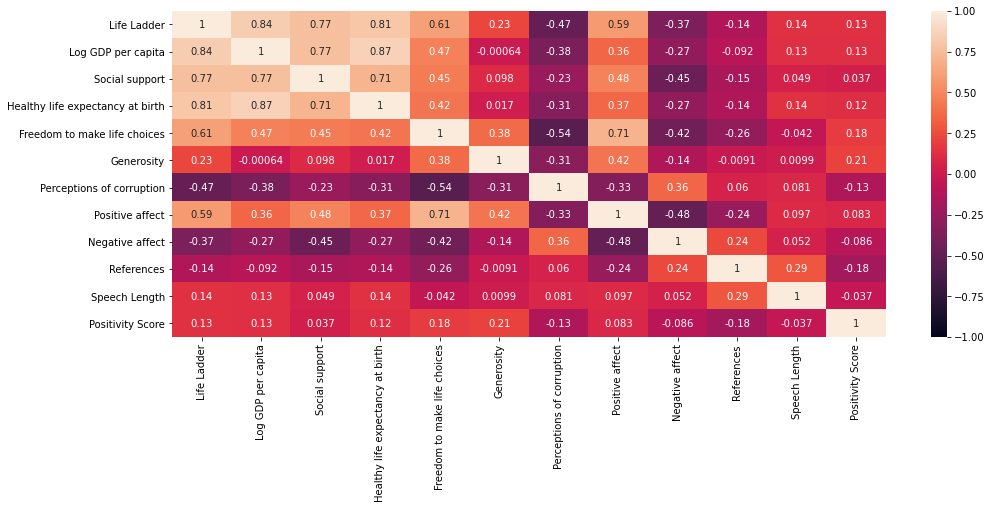

In [36]:
plt.figure(figsize=(16, 6))
sns.heatmap(meanByCountry.loc[:].corr(), vmin=-1, vmax=1, annot=True);
#plt.savefig('Correlation', bbox_inches='tight') 